# UPPP 214 - Week 4

In [1]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from fsspec import filesystem

<a target="_blank" href="https://colab.research.google.com/github/knaaptime/uppp214-winter26-assn/blob/main/week4/relationships.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Data Preparation

For class assignments and exercises, I generally give you a good dataset to start with. But it can also be very instructive to see how we go from zero to 'tidy data'.

We start by reading in three datasets:

1. traffic collisions in CA
2. census demographic information
3. environmental data from EJSCREEN

the first is a set of points, the latter two are *blockgroup* polygons

In [2]:
fs = filesystem("https")

collisions = gpd.read_parquet("https://github.com/oturns/example_datasets/raw/refs/heads/main/collisions/ca_collisions.pq", filesystem=fs)
bgs = gpd.read_parquet("https://github.com/oturns/example_datasets/raw/refs/heads/main/acs/ca_blockgroups_2021.pq", filesystem=fs)
environment = gpd.read_parquet("https://github.com/oturns/example_datasets/raw/refs/heads/main/environment/ca_ejscren_2021.pq", filesystem=fs)

the Los Angeles metropolitan region contains two counties: LA and Orange. Their FIPS codes are `06037` and `06059`, respectively

In [3]:
la_msa_fips = ['06037', '06059']

we can use those two counties as a filter. As we know, FIPS codes are hierarchical; so if we want all blockgroups in LA and OC, then we want all those whose first 5 characters of the FIPS code (called `geoid`) are either 06059 or 06037. We can select those using "string methods"

In [6]:
bgs = bgs[bgs.geoid.str[:5].isin(la_msa_fips)]

In [7]:
bgs.head()

,geoid,n_total_housing_units,n_vacant_housing_units,n_occupied_housing_units,n_owner_occupied_housing_units,n_renter_occupied_housing_units,n_housing_units_multiunit_structures_denom,n_housing_units_multiunit_structures,n_total_housing_units_sample,median_home_value,...,p_hispanic_persons,p_native_persons,p_asian_persons,p_hawaiian_persons,p_asian_indian_persons,p_edu_hs_less,p_edu_college_greater,p_veterans,geometry,year
3978,060371011101,640.0,45.0,595.0,339.0,256.0,640.0,200.0,640.0,610800.0,...,35.030675,0.000000,3.558282,0.0,3.558282,15.817223,28.558875,0.613497,"MULTIPOLYGON (((-118.29133 34.26008, -118.2913...",2021
3979,060371011102,660.0,100.0,560.0,264.0,296.0,660.0,244.0,660.0,484200.0,...,21.045576,0.402145,15.549598,0.0,15.549598,5.291829,25.136187,1.407507,"MULTIPOLYGON (((-118.30229 34.2587, -118.30091...",2021
3980,060371011103,339.0,0.0,339.0,247.0,92.0,339.0,18.0,339.0,526100.0,...,15.852048,0.000000,15.191546,0.0,15.191546,6.521739,29.503106,3.830911,"MULTIPOLYGON (((-118.3008 34.26327, -118.29792...",2021
3981,060371011221,840.0,54.0,786.0,602.0,184.0,840.0,27.0,840.0,712600.0,...,4.486196,0.000000,15.260736,0.0,15.260736,20.734908,38.162730,4.141104,"MULTIPOLYGON (((-118.30334 34.27371, -118.3033...",2021
3982,060371011222,586.0,0.0,586.0,426.0,160.0,586.0,33.0,586.0,700200.0,...,13.544844,0.000000,12.751678,0.0,12.751678,8.863820,38.356164,1.342282,"MULTIPOLYGON (((-118.29075 34.26906, -118.2906...",2021


In [8]:
bgs['county'] = bgs.geoid.str[:5]

<Axes: >

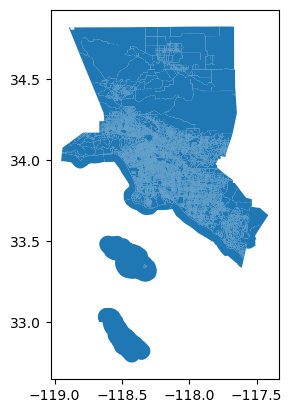

In [9]:
bgs.plot()

lets consider only places where there is non-zero population

In [16]:
bgs = bgs[bgs['n_total_pop']>0]

<Axes: >

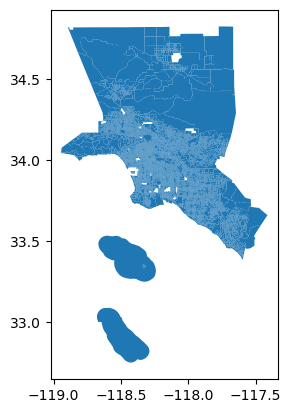

In [11]:
bgs.plot()

the `environment` dataset has data from the EPA environmental justice screening tool. Most useful for our purposes are the estiamtes of different chemical emissions like Ozone and PM2.5. Since both datasets are at the blockgroup level and both have FIPS codes, we can use that information to merge them together

In [12]:
environment.head()

,geoid,ACSTOTPOP,ACSIPOVBAS,ACSEDUCBAS,ACSTOTHH,ACSTOTHU,ACSUNEMPBAS,MINORPOP,MINORPCT,LOWINCOME,...,P_PM25_D2,P_UST_D2,AREALAND,AREAWATER,NPL_CNT,TSDF_CNT,Shape_Length,Shape_Area,geometry,year
0,060014001001,3120,3099,2509,1293,1354,1680,803,0.257372,323,...,2.946015,20.988353,6894339.0,0.0,0,0,18116.602374,1.108122e+07,"MULTIPOLYGON (((-13608466.355 4563255.362, -13...",2021
1,060014002001,990,990,743,422,435,582,229,0.231313,76,...,22.109089,2.293023,288069.0,0.0,0,0,3776.258099,4.627897e+05,"MULTIPOLYGON (((-13609375.167 4557703.988, -13...",2021
2,060014002002,1017,1004,822,425,425,644,303,0.297935,136,...,31.751170,3.559113,298490.0,0.0,0,0,4019.010837,4.794874e+05,"MULTIPOLYGON (((-13609691.203 4557215.817, -13...",2021
3,060014003001,1134,1134,823,405,449,707,399,0.351852,25,...,23.300115,2.393727,265695.0,0.0,0,0,3231.259100,4.267776e+05,"MULTIPOLYGON (((-13609015.939 4557517.485, -13...",2021
4,060014003002,1237,1197,1034,697,758,942,229,0.185125,118,...,14.585397,2.410279,269347.0,0.0,0,0,4482.836688,4.325698e+05,"MULTIPOLYGON (((-13610179.005 4556546.68, -136...",2021


See [here](https://open.quiltdata.com/b/spatial-ucr/tree/epa/ejscreen/) for a list of columns and what they mean

pandas `merge` function combines two dataframes based on their share values in a given column (if you're from SQL or database world, this is a *table join*). Since we already dropped blockgroups from `bgs` that have non-zero population, we want to use a "left-join", which means we only retain rows if they are in the left-hand dataframe (bgs)

In [13]:
df = bgs.merge(environment, on='geoid', how='left')

now the dataframe `df` has information from both Census and EPA

In [14]:
df.shape

(8606, 150)

In [15]:
df.columns

Index(['geoid', 'n_total_housing_units', 'n_vacant_housing_units',
       'n_occupied_housing_units', 'n_owner_occupied_housing_units',
       'n_renter_occupied_housing_units',
       'n_housing_units_multiunit_structures_denom',
       'n_housing_units_multiunit_structures', 'n_total_housing_units_sample',
       'median_home_value',
       ...
       'P_PM25_D2', 'P_UST_D2', 'AREALAND', 'AREAWATER', 'NPL_CNT', 'TSDF_CNT',
       'Shape_Length', 'Shape_Area', 'geometry_y', 'year_y'],
      dtype='object', length=150)

remember we can look at a empirical distribution of single column via the `plot` or `hist` methods

<Axes: >

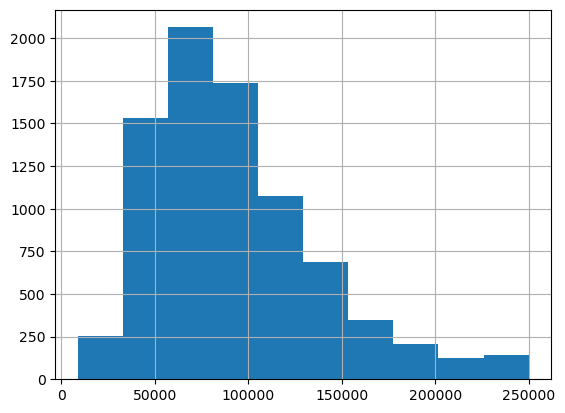

In [17]:
df['median_household_income'].hist()

<Axes: ylabel='Frequency'>

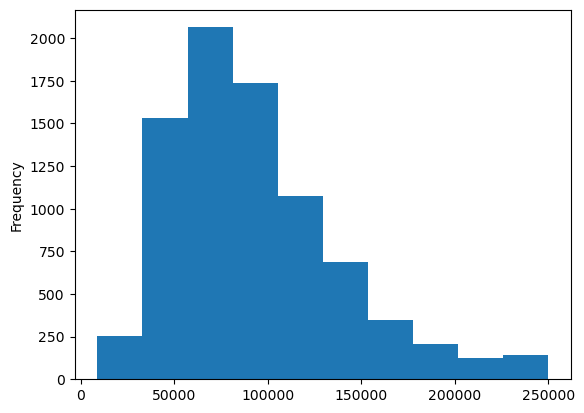

In [18]:
df['median_household_income'].plot(kind='hist')

<Axes: ylabel='Frequency'>

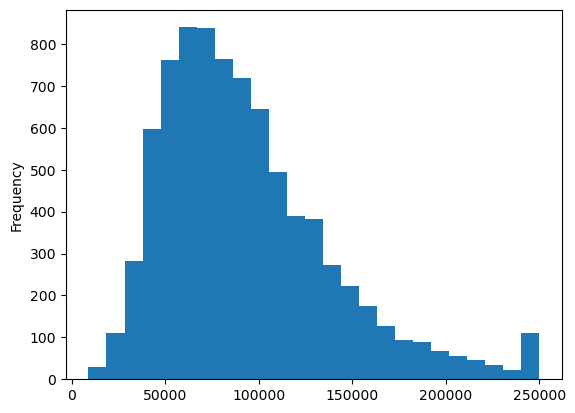

In [19]:
df['median_household_income'].plot(kind='hist', bins=25)

<Axes: ylabel='Density'>

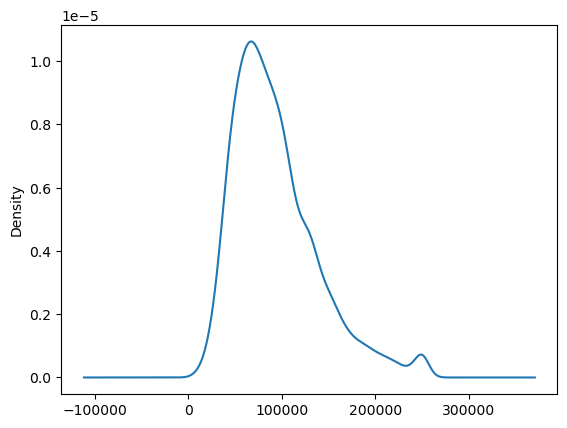

In [20]:
df['median_household_income'].plot(kind='density')

income usually follows a log-normal distribution, so if we take the logarithm, we get something very close to a Normal distribution

...except that it's top-coded at $250,000

<Axes: >

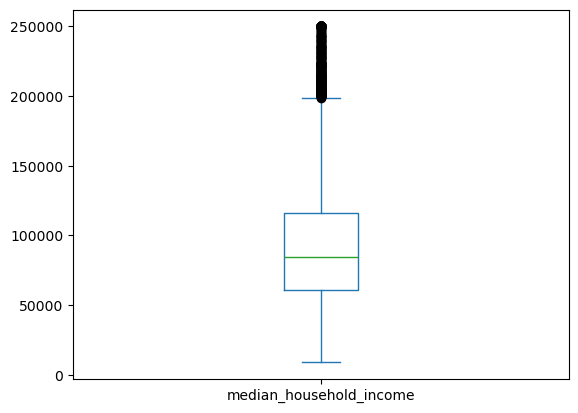

In [21]:
df['median_household_income'].plot(kind='box')

In [22]:
df.plot?

Signature:      df.plot(*args, **kwargs)
Type:           GeoplotAccessor
String form:    <geopandas.plotting.GeoplotAccessor object at 0x3a7ac9a90>
File:           /opt/miniconda3/envs/uppp214-winter26/lib/python3.13/site-packages/geopandas/plotting.py
Docstring:     
Plot a GeoDataFrame.

Generate a plot of a GeoDataFrame with matplotlib.  If a
column is specified, the plot coloring will be based on values
in that column.

Parameters
----------
column : str, np.array, pd.Series, pd.Index (default None)
    The name of the dataframe column, np.array, pd.Series, or pd.Index
    to be plotted. If np.array, pd.Series, or pd.Index are used then it
    must have same length as dataframe. Values are used to color the plot.
    Ignored if `color` is also set.
kind: str
    The kind of plots to produce. The default is to create a map ("geo").
    Other supported kinds of plots from pandas:

    - 'line' : line plot
    - 'bar' : vertical bar plot
    - 'barh' : horizontal bar plot
    - 'hist'

<Axes: ylabel='median_household_income'>

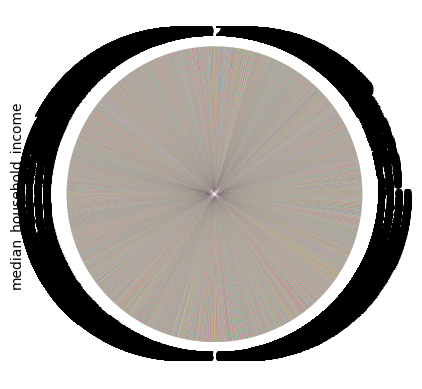

In [26]:
df['median_household_income'].plot(kind='pie')

<Axes: ylabel='Frequency'>

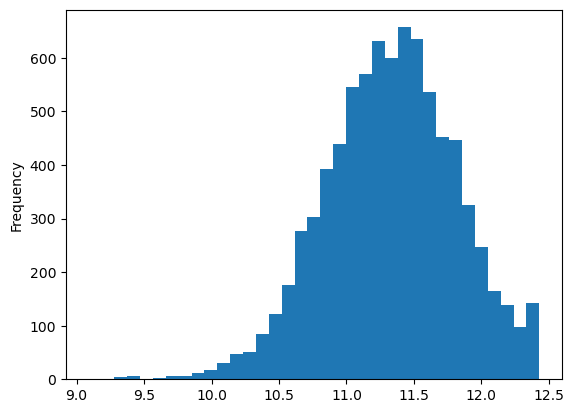

In [27]:
df['median_household_income'].apply(np.log).plot(kind='hist', bins=35)

<Axes: ylabel='Frequency'>

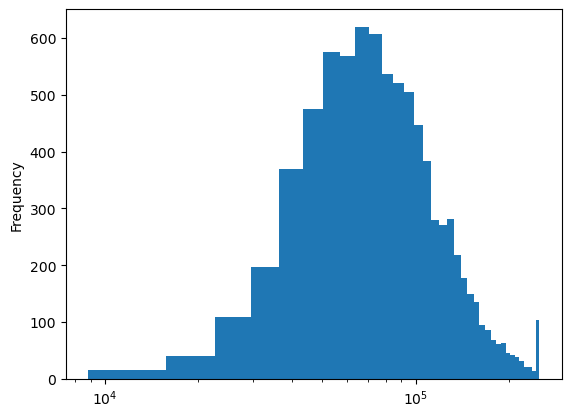

In [28]:
df['median_household_income'].plot(kind='hist', logx=True, bins=35)

<Axes: title={'center': 'Histogram of Median Household Income'}, xlabel='Median Home Value', ylabel='Frequency'>

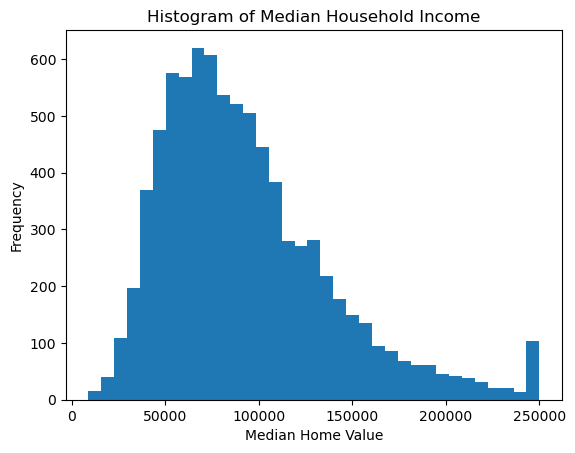

In [29]:
df['median_household_income'].plot(kind='hist', bins=35, title='Histogram of Median Household Income', xlabel='Median Home Value')

We can also create plots using `seaborn`

In [ ]:
sns.histplot?

<Axes: xlabel='median_home_value', ylabel='Count'>

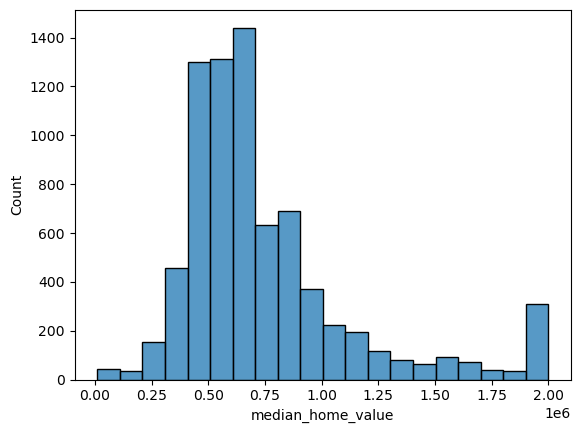

In [30]:
sns.histplot(data=df, x='median_home_value', bins=20)

With seaborn we can easily combine the density and histogram plots into one to see how the continuous kernel density estimate falls over the bins

<Axes: xlabel='median_home_value', ylabel='Count'>

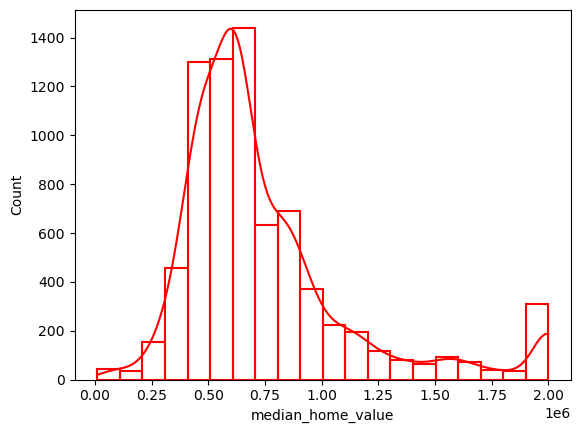

In [33]:
sns.histplot(data=df, x='median_home_value', bins=20, kde=True, color='red', fill=False)

<Axes: xlabel='median_home_value'>

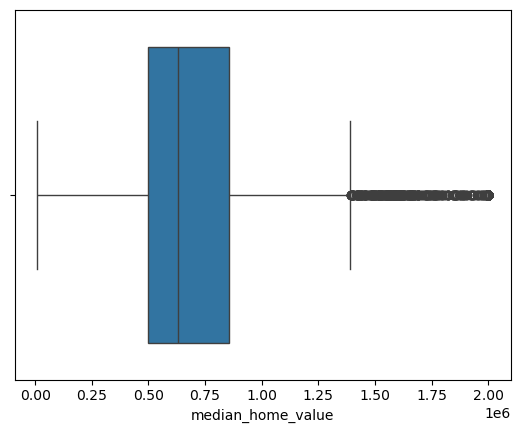

In [32]:
sns.boxplot(data=df, x='median_home_value')

Text(0.5, 0, 'Median Home Values')

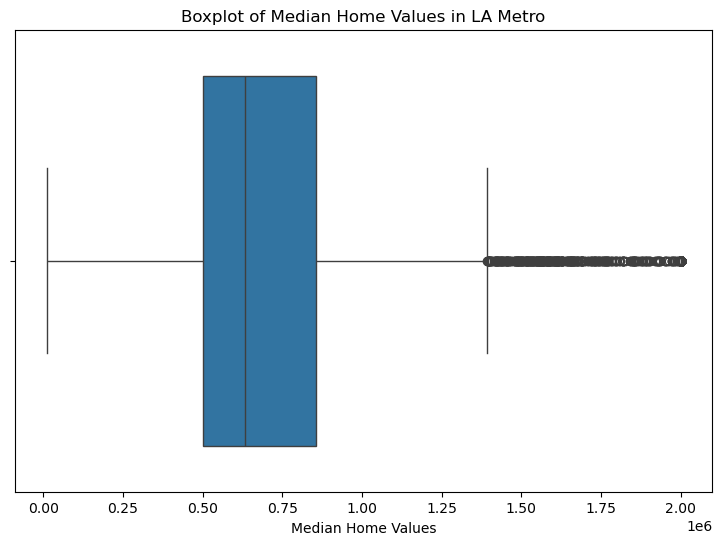

In [34]:
fig, ax = plt.subplots(figsize=(9,6))
sns.boxplot(data=df, x='median_home_value', ax=ax)

ax.set_title('Boxplot of Median Home Values in LA Metro')
ax.set_xlabel('Median Home Values')


<Axes: xlabel='county', ylabel='median_home_value'>

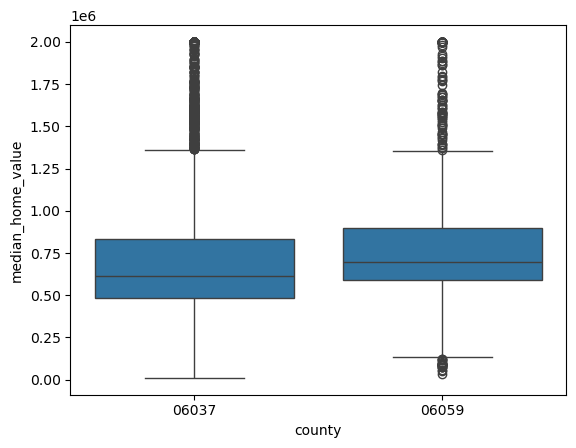

In [35]:
sns.boxplot(data=df, y='median_home_value', x='county')

In [ ]:
sns.violinplot?

<Axes: xlabel='median_home_value'>

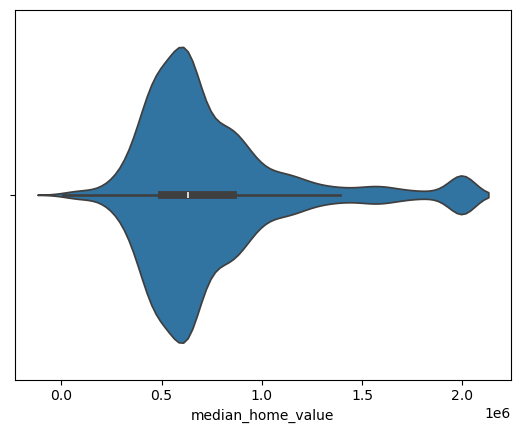

In [36]:
sns.violinplot(data=df, x='median_home_value',)

<Axes: xlabel='county', ylabel='median_home_value'>

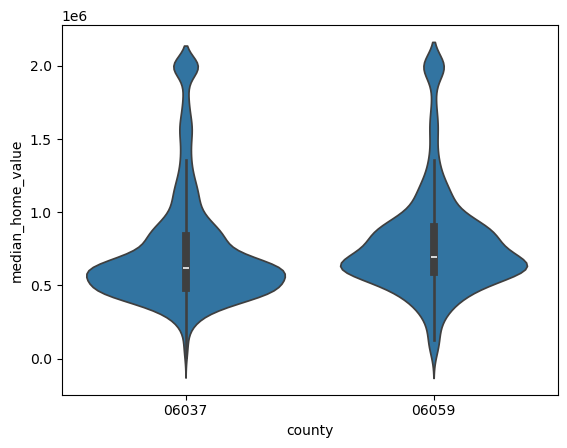

In [37]:
sns.violinplot(data=df, y='median_home_value', x='county')

In [ ]:
sns.violinplot(data=df, y='p_edu_college_greater', x='county')

seaborn also has multiple "styles" preconfigured for different aesthethics

In [ ]:
sns.set_style?

In [ ]:
for style in ['darkgrid', 'whitegrid', 'dark', 'white', 'ticks']:
    sns.set_style(style)
    ax = sns.violinplot(data=df, y='p_edu_college_greater', x='county',)
    ax.set_title(style)
    plt.show()

Now we can look at relationships between two or more variables

In [ ]:
df[['median_home_value', 'p_edu_college_greater']]

In [ ]:
df[['median_home_value', 'p_edu_college_greater']].corr()

In [ ]:
sns.scatterplot?

In [ ]:
sns.scatterplot(data=df, x='median_home_value', y='p_edu_college_greater')

In [ ]:
sns.scatterplot(data=df, x='median_home_value', y='p_edu_college_greater', alpha=0.2)

We can add a third 'visual variable', like color/hue, to differentiate between a (third) categorical variable. For instance we can look at the scatterplots by county

In [ ]:
sns.scatterplot(data=df, x='median_home_value', y='p_edu_college_greater', hue='county',alpha=0.2)

the `corr` method in the dataframe returns the pairwise correlation coefficient for each pair of inputs. The correlation between educational attainment and median home values is quite high at 0.69

In [ ]:
cols = ['median_home_value', 'p_edu_college_greater', 'median_household_income', 'p_edu_hs_less', 'p_married', 'p_vacant_housing_units', 'p_persons_over_60']

In [ ]:
df[cols]

In [ ]:
df[cols].corr()

To look at rank correlation, we specify `method='spearman'`

In [ ]:
df[cols].corr('spearman')

many of these variables have extreme values, so some of the correlations change a bit; the relationship between home values and income stays roughly the same. But the correlation between home values and education gets even stronger

the `corr` method gives back a correlation matrix, so one useful way of understanding correlation among multiple groups is via a [heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html)

In [ ]:
sns.heatmap?

In [ ]:
sns.heatmap(df[cols].corr(), cmap='RdBu_r')

the default options are not perfect. To make this better we can specify the range ourselves. We know the correlation coefficient varies from -1 to 1, so lets set those as the max and min values, and place the value of the correlation coefficient in each cell

In [ ]:
sns.heatmap(df[cols].corr(), cmap='RdBu_r', vmin=-1, vmax=1, annot=True)

Another option is to use a [pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html) which gives pairwise scatterplots and a histogram along the diagonal

In [ ]:
sns.pairplot(df[cols])

### Demographics and the Environment

lets look at some examples together:

|var |description|
-----|------------|
| DSLPM	| Diesel particulate matter level in air|
| CANCER |	Air toxics cancer risk|
| RESP	| Air toxics respiratory hazard index|
| PTRAF	| Traffic proximity and volume|
| PWDIS	| Indicator for major direct dischargers to water|
| PNPL	| Proximity to National Priorities List (NPL) sites|
| PRMP	| Proximity to Risk Management Plan (RMP) facilities|
| PTSDF	| Proximity to Treatment Storage and Disposal (TSDF) facilities|
| OZONE	| Ozone level in air|
| PM25	| PM2.5 level in air|

### Collision Data

We can also look at some relationships between the datasets above and the prevalence of traffic accidents

In [ ]:
collisions.head()

In [ ]:
collisions = collisions[collisions["ACCIDENT_YEAR"] ==2023]

In [ ]:
collisions.shape

In [ ]:
collisions_by_bg = bgs.sjoin(collisions, how='left')

In [ ]:
collisions_by_bg

In [ ]:
collisions_by_bg = collisions_by_bg.groupby('geoid')['CASE_ID'].count()

In [ ]:
collisions_by_bg

In [ ]:
collisions_by_bg = collisions_by_bg.rename('collisions')

In [ ]:
collisions_by_bg

In [ ]:
df = df.merge(collisions_by_bg, left_on='geoid', right_index=True)

In [ ]:
df.head()

In [ ]:
df['collisions'].describe()

In [ ]:
df = df.set_geometry('geometry_x')

In [ ]:
df[['collisions', 'geometry_x']].explore('collisions', scheme='fisherjenks', style_kwds={'weight':0.5}, tiles='cartodb positron')

In [ ]:
df.collisions.hist()

In [ ]:
df.collisions.apply(np.log1p).hist()

In [ ]:
df[['n_total_pop', 'collisions']]

In [ ]:
df[['n_total_pop', 'collisions']].corr()

essentially 0 correlation between blockgroup popuolation and the number of collisions

In [ ]:
df['coll_per_capita'] = df['collisions'] / df['n_total_pop']

In [ ]:
df['coll_per_capita']

In [ ]:
df['coll_per_capita'].describe()

In [ ]:
df[['collisions', 'median_home_value']].corr()

In [ ]:
df[['coll_per_capita', 'median_home_value']].corr()

In [ ]:
df[['coll_per_capita', 'median_home_value']].corr()

In [ ]:
sns.scatterplot(data=df, y='collisions', x='median_home_value', alpha=0.5)

In [ ]:
sns.scatterplot(data=df, y='collisions', x='median_home_value')
sns.despine()

In [ ]:
df[['collisions', 'PTRAF']].corr()

In [ ]:
sns.scatterplot(data=df, x='PTRAF', y='collisions', alpha=0.2)

In [ ]:
sns.scatterplot(data=df, x='PTRAF', y='collisions', alpha=0.2, hue='county')

In [ ]:
# convert the coordinate system to UTM for accurate area measurement in meters
df = df.to_crs(df.estimate_utm_crs())

In [ ]:
df['sqm'] = df.area

In [ ]:
df[['sqm', 'collisions']].corr()

looking back at the map, we can intuit a bit of what's happening. There are few collisions in the very small polygons because there aren't many opportunities to collide; they are small enough that there's few cars in the polygon at any given time. But the largest polygons are in every rural areas, presumably with few roads or cars